In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
# Data preprocessing
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split

In [185]:
# For imputing missing values for level_binary
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

In [212]:
# Libraries for predicting
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [ ]:
# Libraries for hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [379]:
# Libraries for feature selection
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC, LinearSVR

In [169]:
import pickle

In [3]:
reg_data = pd.read_csv("forecasting_dataset.csv")

In [216]:
reg_data.shape

(8421, 18)

In [23]:
reg_data.head()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level,level_binary
0,10/13/2004,20:00:00,943,-200.0,-200.0,7.2,867.0,-200.0,834.0,-200.0,1314.0,891.0,14.8,57.3,0.9603,NaN,NaN
1,8/10/2004,3:00:00,919,0.5,-200.0,3.9,704.0,-200.0,861.0,-200.0,1603.0,860.0,24.4,65.0,1.9612,Low,-1.0
2,6/21/2004,8:00:00,1221,3.7,-200.0,23.3,1386.0,NaN,626.0,109.0,2138.0,NaN,23.3,38.6,1.0919,High,1.0
3,7/12/2004,12:00:00,1024,2.1,-200.0,12.1,1052.0,183.0,779.0,NaN,1690.0,952.0,28.5,27.3,1.0479,High,1.0
4,12/14/2004,12:00:00,1377,4.4,-200.0,21.7,1342.0,786.0,499.0,206.0,1546.0,2006.0,12.9,54.1,0.8003,High,1.0


In [396]:
# I am making the assumption that the value of y given is 6 hours ahead

### Encoding categorical variables

In [9]:
#I have made the assumption that the difference between all the levels are the same. 
reg_data["level"].unique()

array([nan, 'Low', 'High', 'Very low', 'Moderate', 'Very High'], dtype=object)

In [10]:
reg_data["level_binary"] = reg_data["level"].map( {'Very low': -2, 'Low':-1, 'moderate':0, 'High':1, 'Very High':2 } )

### Extracting hour

In [336]:
reg_data['hour'] = reg_data['time'].apply(lambda item: int(item.split(":")[0]))

In [337]:
reg_data.head()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level,level_binary,hour
0,10/13/2004,20:00:00,943,-200.0,-200.0,7.2,867.0,-200.0,834.0,-200.0,1314.0,891.0,14.8,57.3,0.9603,NaN,NaN,20
1,8/10/2004,3:00:00,919,0.5,-200.0,3.9,704.0,-200.0,861.0,-200.0,1603.0,860.0,24.4,65.0,1.9612,Low,-1.0,3
2,6/21/2004,8:00:00,1221,3.7,-200.0,23.3,1386.0,NaN,626.0,109.0,2138.0,NaN,23.3,38.6,1.0919,High,1.0,8
3,7/12/2004,12:00:00,1024,2.1,-200.0,12.1,1052.0,183.0,779.0,NaN,1690.0,952.0,28.5,27.3,1.0479,High,1.0,12
4,12/14/2004,12:00:00,1377,4.4,-200.0,21.7,1342.0,786.0,499.0,206.0,1546.0,2006.0,12.9,54.1,0.8003,High,1.0,12


In [338]:
# Checking if variable is categorical
reg_data['nhmc'].unique()

array([ -200.,    nan,   260.,   226.,   698.,   299.,    95.,   391.,
         169.,   205.,   234.,    78.,   112.,   277.,   145.,    63.,
          29.,   235.,   259.,    66.,   802.,   114.,   160.,    94.,
         236.,    48.,   685.,    67.,   196.,    59.,   524.,    47.,
          43.,    87.,   194.,   325.,    58.,   475.,    68.,    53.,
         141.,    23.,   193.,   151.,    55.,    32.,   181.,   148.,
         203.,   368.,   179.,    49.,    61.,    40.,    34.,    56.,
         336.,   212.,    39.,    98.,   798.,   265.,   434.,    44.,
          52.,   346.,   183.,   238.,     9.,   128.,   538.,   116.,
          74.,    31.,   542.,   221.,   143.,   284.,   219.,   216.,
          62.,   222.,    88.,   102.,   446.,   152.,   118.,   415.,
         156.,    76.,   267.,   207.,   134.,   454.,   559.,    26.,
         200.,   202.,    50.,   159.,   126.,   157.,   136.,    33.,
         109.,    64.,   565.,    75.,   743.,    65.,    25.,   173.,
      

### Splitting data

In [339]:
encoded_data = reg_data.drop(['date', 'time', 'level'], axis = 1)
#y = reg_data['y']

In [340]:
# Train test split
train_data, test_data = train_test_split(encoded_data, test_size=0.15, random_state=7)

In [341]:
# Train test split
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=7)

### Imputing `level_binary` using classification as there is high correlation between some features

In [342]:
# # Setting up training data
# train = X_train[np.invert(X_train.isnull()['level_binary'])]
# train_X = train.drop(['level_binary'], axis = 1)
# train_y = train['level_binary']

# data_imputer = Imputer()
# train_X_imp = data_imputer.fit_transform(train_X)

# train_X = pd.DataFrame(train_X_imp, columns=train_X.columns)

In [343]:
# #setting up predicting data
# predict = X_train[X_train.isnull()['level_binary']]
# predict_X = predict.drop(['level_binary'], axis = 1)
# data_imputer = Imputer()
# predict_X_imp = data_imputer.fit_transform(predict_X)
# predict_X = pd.DataFrame(predict_X_imp, columns=predict_X.columns)

#### Developing model to predict `level_binary`

In [344]:
# gbt = GradientBoostingClassifier()
# cross_val_score(gbt, train_X, train_y, cv=3)
# #array([ 0.99086022,  0.99193548,  0.99301075])
# gbt.fit(train_X, train_y)
# predict_y = gbt.predict(predict_X)
# cbind = pd.concat([predict_X.head().reset_index(drop=True), pd.DataFrame(predict_y, columns=["label"]).head()], axis=1)
# predict_X.head()
# pd.DataFrame(predict_y, columns=["label"]).head()

In [345]:
def impute_label(data, fit = False):
    
    # Data with level_binary
    train = data[np.invert(data.isnull()['level_binary'])]
    data_imputer = Imputer()
    train_imp = data_imputer.fit_transform(train)
    train = pd.DataFrame(train_imp, columns=train.columns)
    target_train = train['y']
    
    
    # Data missing level_binary
    predict = data[data.isnull()['level_binary']]
    predict_X = predict.drop(['level_binary', 'y'], axis = 1)
    target_predict = predict['y']
    predict_X_imp = data_imputer.fit_transform(predict_X)
    predict_X = pd.DataFrame(predict_X_imp, columns=predict_X.columns)
    
    if fit:
        #Preparing data to train
        train_X = train.drop(['level_binary', 'y'], axis = 1)
        train_y = train['level_binary']
        
        #Fit model
        gbt = GradientBoostingClassifier()
        gbt.fit(train_X, train_y)
        
        #Save model
        save_classifier = open("predict_level.pickle", "wb")
        pickle.dump(gbt, save_classifier)
        save_classifier.close()
        
        #Make predictions
        predict_y = gbt.predict(predict_X)
        
        # Removing target variable from initial dataframe
        train.drop(['y'], inplace=True, axis = 1)
    else:
        train.drop(['y'], inplace=True, axis = 1)
        #Load saved model
        classifier_f = open("predict_level.pickle", "rb")
        gbt = pickle.load(classifier_f)
        classifier_f.close()
        
        #Make predictions
        predict_y = gbt.predict(predict_X)
    
    #Concatenate the label with remaining data
    predict_imputed = pd.concat([predict_X.reset_index(drop=True),
                                 pd.DataFrame(predict_y, columns=["level_binary"])], axis=1)
    
    #Combine 
    X_data = pd.concat([train.reset_index(drop=True), predict_imputed], axis=0, ignore_index=True)
    
    y_data = pd.concat([target_train.reset_index(drop=True), target_predict], axis=0, ignore_index=True)
    
    return X_data, y_data

In [346]:
X_train, y_train = impute_label(train_data, fit=True)
X_val, y_val = impute_label(val_data)
X_test, y_test = impute_label(test_data)

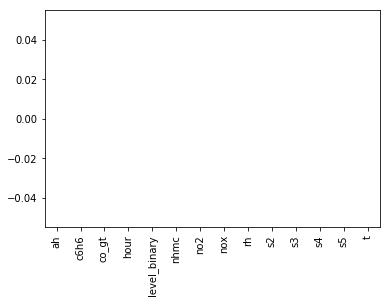

In [347]:
X_train.isnull().sum().plot(kind='bar')

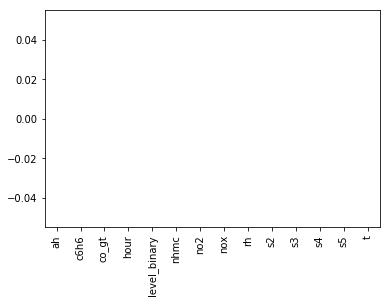

In [348]:
X_val.isnull().sum().plot(kind='bar')

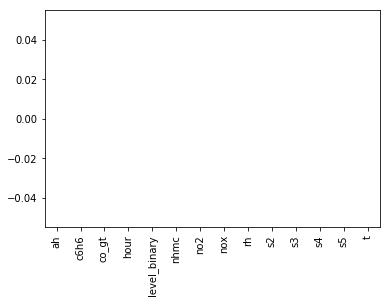

In [349]:
X_test.isnull().sum().plot(kind='bar')

In [ ]:
# assuming that the y value is the prediction after 6 hours.

In [205]:
def fit_evaluate(model): 
    model.fit(X_train, y_train)
    train_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_train),y_true=y_train))
    val_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_val),y_true=y_val))
    print("Train RMSE: ", train_rmse)
    print("Validation RMSE: ", val_rmse)

## Linear Regression with L2

In [351]:
lm_ridge = Ridge()
fit_evaluate(lm_ridge)

Train RMSE:  79.7253515825
Validation RMSE 75.7225586488


## Linear Regression with L1

In [352]:
lm_lasso = Lasso()
fit_evaluate(lm_lasso)

Train RMSE:  79.7409772433
Validation RMSE 75.7733661698


## Random Forest Regressor

In [353]:
rf_reg = RandomForestRegressor()
fit_evaluate(rf_reg)

Train RMSE:  26.2214377774
Validation RMSE 61.2192863745


## K Neighbors Regressors

In [354]:
kn_reg = KNeighborsRegressor()
fit_evaluate(kn_reg)

Train RMSE:  54.9240420598
Validation RMSE 66.1490892694


## Support Vector Regressor

In [355]:
sv_reg = SVR()
fit_evaluate(sv_reg)

Train RMSE:  342.097216367
Validation RMSE 340.793481167


## GradientBoostingRegressor

In [356]:
gb_reg = GradientBoostingRegressor()
fit_evaluate(gb_reg)

Train RMSE:  60.1988291462
Validation RMSE 62.7694025553


## AdaBoostRegressor

In [357]:
ab_reg = AdaBoostRegressor()
fit_evaluate(ab_reg)

Train RMSE:  94.1325517621
Validation RMSE 96.2058734137


# Discarding missing data & Repeat Analysis

In [358]:
nreg_data = reg_data.dropna(how="any")
X = nreg_data.drop(['date', 'time', 'y', 'level'], axis = 1)
y = nreg_data['y']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)
# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=7)

## Linear Regression with L2

In [360]:
lm_ridge = Ridge()
fit_evaluate(lm_ridge)

Train RMSE:  70.4145706828
Validation RMSE 73.3346814294


## Linear Regression with L1

In [361]:
lm_lasso = Lasso()
fit_evaluate(lm_lasso)

Train RMSE:  70.4575607478
Validation RMSE 73.3923384891


/Users/avinash/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Random Forest Regressor

In [362]:
rf_reg = RandomForestRegressor()
fit_evaluate(rf_reg)

Train RMSE:  25.7376566707
Validation RMSE 62.5477714061


## K Neighbors Regressors

In [363]:
kn_reg = KNeighborsRegressor()
fit_evaluate(kn_reg)

Train RMSE:  51.1340994283
Validation RMSE 64.1751705051


## Support Vector Regressor

In [364]:
sv_reg = SVR()
fit_evaluate(sv_reg)

Train RMSE:  332.364538279
Validation RMSE 333.170333174


## GradientBoostingRegressor

In [365]:
gb_reg = GradientBoostingRegressor()
fit_evaluate(gb_reg)

Train RMSE:  53.4535252779
Validation RMSE 65.3974484768


## AdaBoostRegressor

In [366]:
ab_reg = AdaBoostRegressor()
fit_evaluate(ab_reg)

Train RMSE:  80.2318135482
Validation RMSE 79.5669598433


## XGBRegressor

In [367]:
xgb_reg = XGBRegressor()
fit_evaluate(xgb_reg)

Train RMSE:  53.5669636342
Validation RMSE 64.8392549149


## Hyperparameter tuning for RandomForestRegressor

In [316]:
parameters = {'n_estimators': np.arange(100,300,50),
              'max_features': ['auto', 'sqrt'],
              'max_depth': [None, 5, 7, 10]}

In [321]:
rf_reg = RandomForestRegressor()
opt_gbc = GridSearchCV(rf_reg, parameters, n_jobs = -1)
opt_gbc.fit(X_train,y_train)
print(opt_gbc.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


In [323]:
rf_reg_opt = RandomForestRegressor(max_depth = None, max_features = 'sqrt', n_estimators = 200)
fit_evaluate(rf_reg_opt)

Train RMSE:  21.2269576837
Validation RMSE 60.8176485107


## Hyperparameter tuning for GradientBoostingRegressor

In [368]:
parameters = {'learning_rate' : np.logspace(-2,0,num=3),
              'n_estimators': [100, 200, 250], 
              'max_depth':[3,5,7], 
              'max_features': ['auto', 'sqrt']}

In [370]:
gb_reg = GradientBoostingRegressor()
opt_gbc = GridSearchCV(gb_reg, parameters, n_jobs = -1)
opt_gbc.fit(X_train,y_train)
print(opt_gbc.best_params_)

{'learning_rate': 0.10000000000000001, 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 250}


In [371]:
gb_reg_opt = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 7,
                                       max_features = 'sqrt', n_estimators = 250)
fit_evaluate(gb_reg_opt)

Train RMSE:  8.56109453363
Validation RMSE 56.9203243769


## Feature Selection

In [380]:
def evaluate(model): 
    train_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_train),y_true=y_train))
    val_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_val),y_true=y_val))
    print("Train RMSE: ", train_rmse)
    print("Validation RMSE: ", val_rmse)

#### Using Extra trees regressor for feature selection

In [381]:
etr_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(ExtraTreesRegressor(n_estimators=250, random_state=7))),
  ('classification', GradientBoostingRegressor(learning_rate = 0.1, max_depth = 7,
                                       max_features = 'sqrt', n_estimators = 250))
])
etr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          ...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))])

In [382]:
evaluate(etr_pipeline)

Train RMSE:  13.7026352474
Validation RMSE:  68.987089725


#### Using Lasso for feature selection

In [393]:
lasso_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(Lasso())),
  ('classification', GradientBoostingRegressor(learning_rate = 0.1, max_depth = 7,
                                       max_features = 'sqrt', n_estimators = 250))
])

lasso_pipeline.fit(X_train, y_train)

/Users/avinash/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
        norm_order=1, prefit=False, threshold=None)),...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))])

In [394]:
evaluate(lasso_pipeline)

Train RMSE:  8.66837474098
Validation RMSE:  56.0470304172


#### Using LinearSVR feature selection

In [389]:
svr_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVR(C=0.1))),
  ('classification', GradientBoostingRegressor(learning_rate = 0.1, max_depth = 7,
                                       max_features = 'sqrt', n_estimators = 250))
])

svr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
        norm_order=1, prefit=False, threshold=None)), ('classific...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))])

In [390]:
evaluate(reg_pipeline)

Train RMSE:  21.9670434982
Validation RMSE:  83.7624509286


## Test RMSE with the best model

In [395]:
test_rmse = np.sqrt(mean_squared_error(y_pred=lasso_pipeline.predict(X_test),y_true=y_test))
print("Test RMSE: ", test_rmse)

Test RMSE:  50.3153802522


## Saving final model

In [397]:
save_classifier = open("task2_model.pickle", "wb")
pickle.dump(lasso_pipeline, save_classifier)
save_classifier.close()